# 닮은 꼴 사람 찾기
dlib을 사용해서 만든 **Face Recognition** 라이브러리를 사용할 것.
> dlib: HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는 face detector

---

## 1. 데이터 불러오기

file_list: ['clinton.jpeg', 'reagan.jpg', 'obama.jpg', 'biden.jpg', 'bush.jpeg', 'trump.jpg']


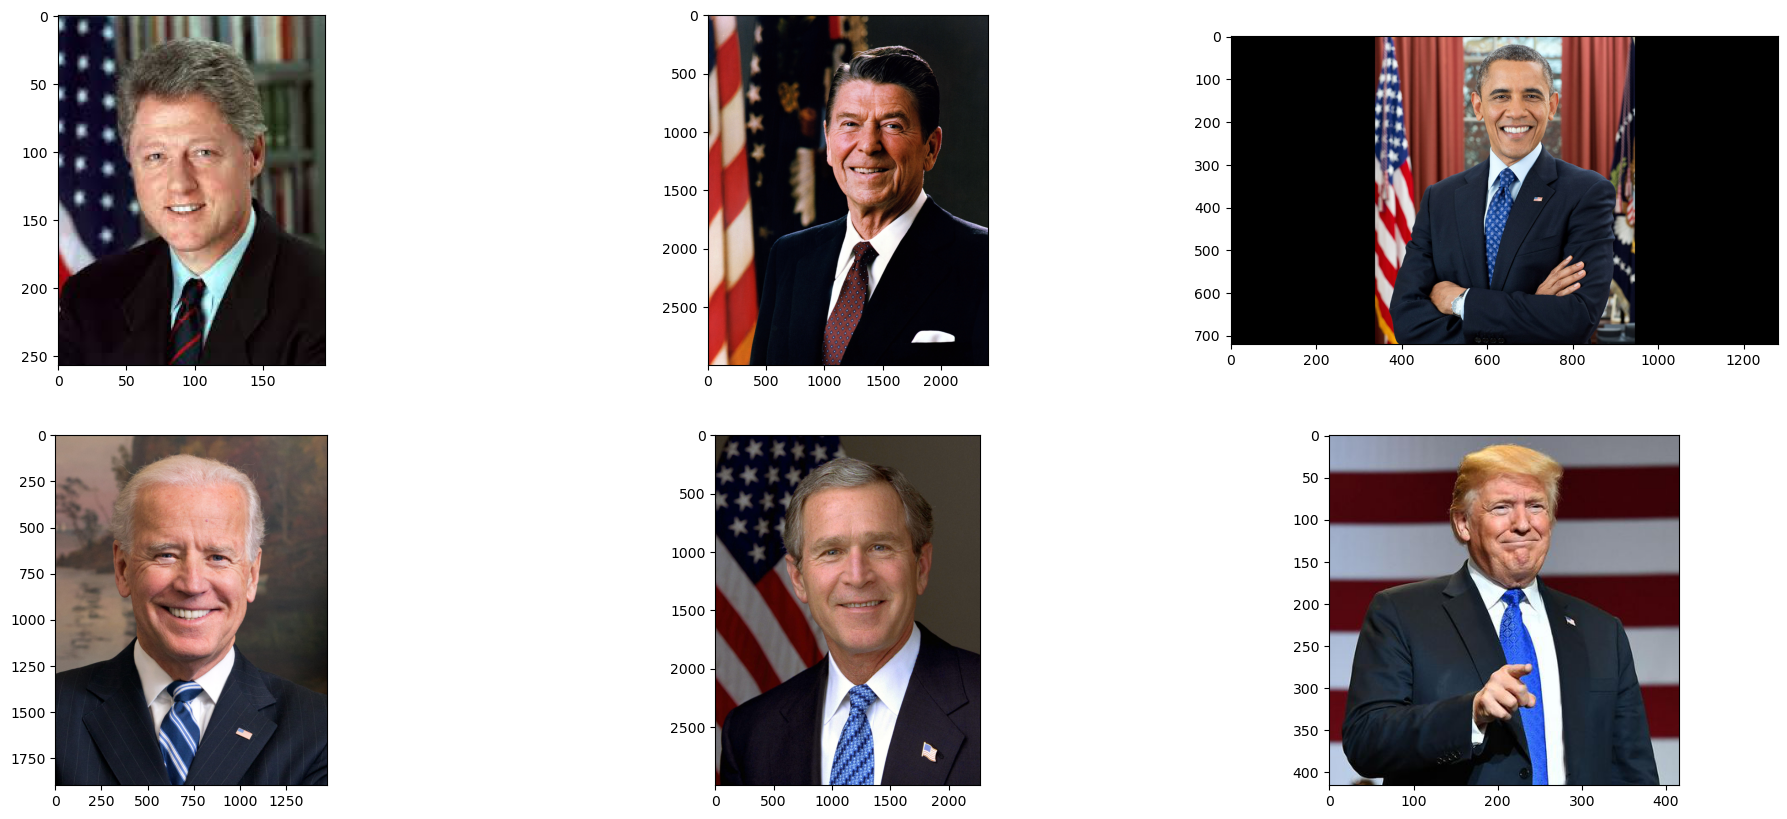

In [1]:
import os

dir_path = os.getenv('HOME')+'/Aiffel_Project/Deep_Learning/Image_Processing/Nearest_Face/Face'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

#### 샘플 이미지에서 loaction을 찾아 자르기

[(98, 758, 284, 572)]


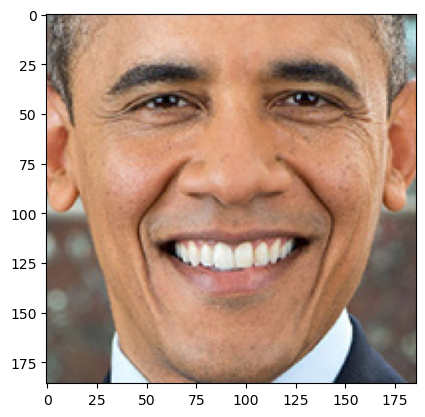

In [2]:
import face_recognition
import matplotlib.pyplot as plt
%matplotlib inline


image_path = os.getenv('HOME')+'/Aiffel_Project/Deep_Learning/Image_Processing/Nearest_Face/Face/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력.

a, b, c, d = face_locations[0]
cropped_face = image[a:c,d:b,:]

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 출력.

#### 위와 같은 작업을 해주는 함수 생성

In [4]:
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

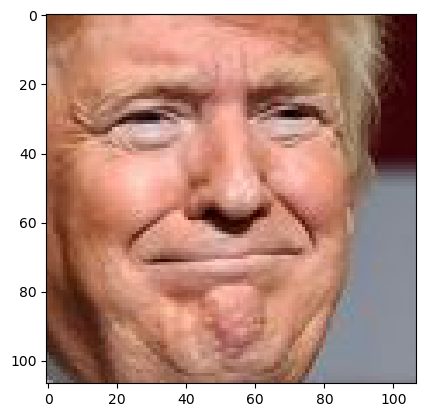

In [5]:
image_path = os.getenv('HOME')+'/Aiffel_Project/Deep_Learning/Image_Processing/Nearest_Face/Face/trump.jpg'

cropped_face = get_cropped_face(image_path)
plt.imshow(cropped_face)

---


## 2. Embedding
Face Recognition은 FaceNet 얼굴 임베딩이 탑재되어 있음.<br>
FaceNet은 네트워크 뒤에 L2 Normalization을 거쳐 임베딩을 만들어 내고 여기에 Triplet Loss를 사용함.
>* Triplet Loss
>![triplet loss](triplet_loss.png)
> __세 개의 데이터 쌍을 이용해 계산하는 손실함수__<br>
> 같은 사람인 임베딩 벡터 A-C는 거리를 가깝게 그리고, 다른 사람인 임베딩 벡터 B-C는 거리를 멀게 학습

#### obama 이미지를 가지고 임베딩

In [6]:
image_file = os.path.join(dir_path, 'obama.jpg')
face = get_cropped_face(image_file)   # 위에서 구현한 얼굴 영역을 구하는 함수

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

[array([-0.08126272,  0.11014772, -0.0108244 , -0.05268788,  0.01033724,
        -0.00813812, -0.07251761, -0.09226455,  0.19304702, -0.09246376,
         0.23908541,  0.06770289, -0.22123131, -0.14119364,  0.05562149,
         0.13705495, -0.17924425, -0.07232308, -0.11183284, -0.11370803,
         0.03956439, -0.01019115,  0.09421781,  0.04493129, -0.12757546,
        -0.34449586, -0.05374935, -0.17703316,  0.00868221, -0.09721591,
        -0.09817188,  0.00278225, -0.17721356, -0.12789804,  0.03489833,
        -0.01991243, -0.00838931, -0.0013287 ,  0.18308595,  0.02447564,
        -0.12376572,  0.0995703 ,  0.02323561,  0.2298332 ,  0.28385243,
         0.0665571 , -0.00558916, -0.09833537,  0.10058987, -0.23476957,
         0.06006302,  0.13415903,  0.08373028,  0.03900502,  0.10194535,
        -0.19337651,  0.01717637,  0.08978966, -0.16005103,  0.01892091,
         0.03082439, -0.06051291, -0.04526762,  0.04633342,  0.20678684,
         0.10299791, -0.12437525, -0.04905149,  0.1

### 2-1. 모든 이미지에 동일한 과정(embedding)을 적용해주는 함수 생성

In [7]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  
        # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
        # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담김. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        
    return embedding_dict

#### trump 이미지에 적용해서 테스트

In [8]:
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962473,  0.20268647,  0.03236349,  0.02439233, -0.06226432,
        0.05140706,  0.07351804, -0.16823359,  0.06962215, -0.05557967,
        0.17270093, -0.05094172, -0.35293117, -0.03164374,  0.03792976,
        0.1734385 , -0.13260119, -0.15357372, -0.23523533, -0.084427  ,
       -0.00134139,  0.03210672, -0.0892615 , -0.02670783, -0.09581182,
       -0.25792345, -0.01057003, -0.11071664,  0.03133567, -0.07444936,
        0.05670553, -0.02273793, -0.19461143, -0.04576057,  0.00947578,
        0.01806072, -0.15026243, -0.07787324,  0.17577599,  0.01933263,
       -0.19744569, -0.03930512,  0.07374467,  0.20196033,  0.14767538,
       -0.01415391,  0.01724748, -0.1197621 ,  0.09462973, -0.24318153,
       -0.02755129,  0.12169884,  0.14837693,  0.17079778,  0.06952558,
       -0.15360461,  0.02005428,  0.08199158, -0.19544819,  0.10653657,
        0.11468489, -0.21902835, -0.0767758 , -0.06791043,  0.10587612,
        0.05921575, -0.0611569 , -0.11171086,  0.23917507, -0.15

---


### 임베딩 사이 거리 측정


#### 같은 사람 2, 다른 사람 1의 예시

![face examples](face_ex.png)
* 예제로 위의 모델의 128차원의 임베딩 벡터를 추출한 뒤, 거리를 어떻게 측정하는지 파악.

In [9]:
import numpy as np

A = np.array([0.0019173615146428347, 0.17689529061317444, 0.0763588473200798, -0.024574430659413338, -0.13141091167926788, 0.0344821996986866, -0.0374063216149807, -0.07056370377540588, 0.048655178397893906, -0.03414120525121689, 0.22696012258529663, -0.061402369290590286, -0.24329672753810883, -0.039421431720256805, 0.0621466189622879, 0.1220191940665245, -0.1616966724395752, -0.06176016479730606, -0.18894734978675842, -0.06051916256546974, -0.010404378175735474, -0.05918719246983528, 0.02205268107354641, -0.06932859122753143, -0.20260301232337952, -0.2425234317779541, -0.04454419016838074, -0.11400106549263, -0.02022719383239746, -0.15134216845035553, 0.07622595876455307, -0.0323314443230629, -0.1404413878917694, -0.056338660418987274, -0.04520038887858391, -0.026131991297006607, -0.0352761372923851, -0.0679447203874588, 0.1318240910768509, 0.034210119396448135, -0.17475582659244537, 0.13853909075260162, -0.0027398746460676193, 0.227312833070755, 0.3029572069644928, 0.004932125099003315, 0.05853061378002167, -0.07521739602088928, 0.1443275809288025, -0.2340908795595169, 0.030092637985944748, 0.040133409202098846, 0.1672351360321045, 0.05728958174586296, 0.11475440859794617, -0.07548368722200394, 0.040267568081617355, 0.16487033665180206, -0.21067440509796143, 0.036163005977869034, 0.051559075713157654, -0.05994952470064163, 0.029524143785238266, -0.04122130945324898, 0.13074155151844025, 0.1142958477139473, -0.00561982998624444, -0.09740489721298218, 0.18533651530742645, -0.10422169417142868, -0.11409182846546173, 0.02283927984535694, -0.08339140564203262, -0.13673236966133118, -0.3275497853755951, -0.0002689119428396225, 0.2842463254928589, 0.13883619010448456, -0.29149484634399414, -0.07276060432195663, -0.03179163485765457, 0.011192545294761658, 0.03802505508065224, 0.03392524644732475, -0.03972085565328598, -0.12013585865497589, -0.06272879987955093, -0.026893358677625656, 0.2430601865053177, -0.12022019177675247, -0.010466678068041801, 0.20199882984161377, 0.051095910370349884, -0.13243277370929718, 0.06056740880012512, -0.04802423343062401, -0.12318279594182968, -0.013157366774976254, -0.12076889723539352, -0.07183175534009933, -0.01982908323407173, -0.15032584965229034, -0.026652328670024872, 0.06820419430732727, -0.24668177962303162, 0.1818322390317917, -0.01959969662129879, -0.07208395004272461, -0.0680316612124443, -0.038368165493011475, 0.021410271525382996, 0.06388168036937714, 0.2293335199356079, -0.22541724145412445, 0.19133104383945465, 0.24343697726726532, -0.04034627974033356, 0.07534503191709518, 0.017645064741373062, 0.054646339267492294, -0.046512290835380554, 0.07076910138130188, -0.0960201621055603, -0.12610889971256256, -0.017934376373887062, -0.010262779891490936, 0.01885927841067314, 0.057148948311805725])

B = np.array([-0.08116298168897629, 0.1283080279827118, 0.024102725088596344, -0.03748808428645134, 0.06578215956687927, -0.07137967646121979, -0.10578329861164093, -0.0911930501461029, 0.19589228928089142, -0.09603863954544067, 0.2447616308927536, 0.07736924290657043, -0.17048686742782593, -0.1277867704629898, 0.06390697509050369, 0.12272421270608902, -0.19242052733898163, -0.08341517299413681, -0.11065894365310669, -0.09501136839389801, -0.010332206264138222, -0.008188878186047077, 0.08251037448644638, 0.04358505830168724, -0.1455313265323639, -0.3595622479915619, -0.07877802848815918, -0.18927346169948578, -0.0018955999985337257, -0.06280332803726196, -0.06073163449764252, 0.03181075677275658, -0.15109844505786896, -0.08682074397802353, 0.017340943217277527, -0.020879391580820084, 0.008258359506726265, 0.016738882288336754, 0.16803768277168274, 0.039162665605545044, -0.09613757580518723, 0.06231086328625679, 0.00924085732549429, 0.2418847680091858, 0.26051488518714905, 0.07355985790491104, 0.05239278823137283, -0.08052310347557068, 0.08884726464748383, -0.24261267483234406, 0.05618546903133392, 0.12175332009792328, 0.09056758135557175, 0.04266638681292534, 0.16591356694698334, -0.2005864679813385, 0.01018378883600235, 0.08819808065891266, -0.15550008416175842, 0.0815843716263771, 0.03018287755548954, -0.025435002520680428, -0.06714558601379395, 0.009693139232695103, 0.22243273258209229, 0.13470745086669922, -0.1363328993320465, 0.01635543815791607, 0.18212205171585083, -0.03392908349633217, 0.0398673489689827, 0.0043264636769890785, -0.15493592619895935, -0.2530894875526428, -0.23155181109905243, 0.0678660124540329, 0.31580865383148193, 0.21846994757652283, -0.20842058956623077, 0.012199334800243378, -0.12194785475730896, 0.059383176267147064, 0.0768171101808548, -0.012840969488024712, -0.11975857615470886, -0.11892750859260559, -0.03087366186082363, 0.04432998597621918, 0.09186872839927673, 0.0821407362818718, -0.018520792946219444, 0.1962793618440628, -0.0566205158829689, 0.026071354746818542, 0.007139421068131924, 0.02185123600065708, -0.11292634904384613, -0.044381096959114075, -0.18024618923664093, -0.007845945656299591, 0.010368190705776215, -0.07480168342590332, -0.0035089245066046715, 0.09972234815359116, -0.18773995339870453, 0.0474785715341568, 0.025760797783732414, -0.042169712483882904, 0.0014017894864082336, 0.1201503798365593, -0.05088714882731438, -0.02051539719104767, 0.0884844958782196, -0.2176845818758011, 0.25695914030075073, 0.23358485102653503, 0.019985560327768326, 0.17838242650032043, 0.029055196791887283, 0.04518195986747742, -0.044122979044914246, -0.043431997299194336, -0.15906637907028198, -0.07155231386423111, 0.02525237947702408, 0.02502967044711113, 0.04127159342169762, 0.011846683919429779])

C = np.array([-0.0762145072221756, 0.09951083362102509, 0.0012626983225345612, -0.05529194697737694, -0.006535547785460949, -0.012212716042995453, -0.07667708396911621, -0.07388101518154144, 0.18756520748138428, -0.07589773088693619, 0.2424328476190567, 0.06438330560922623, -0.22197730839252472, -0.13409815728664398, 0.046808283776044846, 0.14692817628383636, -0.1844339370727539, -0.051137253642082214, -0.1149090975522995, -0.1297808736562729, 0.040612753480672836, -0.002555673476308584, 0.10426937788724899, 0.026295233517885208, -0.13127824664115906, -0.35947439074516296, -0.048153407871723175, -0.17165206372737885, -0.0002263905480504036, -0.10254599899053574, -0.08338439464569092, 0.014203382655978203, -0.18179851770401, -0.13200539350509644, 0.03813670203089714, -0.012789442203938961, -0.0030085663311183453, -0.007307708729058504, 0.17558619379997253, 0.025768719613552094, -0.12877899408340454, 0.11051110923290253, 0.03616628795862198, 0.22539083659648895, 0.2838597595691681, 0.07483825087547302, -0.0036694444715976715, -0.09967216849327087, 0.11106447875499725, -0.22961333394050598, 0.06397823244333267, 0.12394970655441284, 0.06568531692028046, 0.037825535982847214, 0.09586739540100098, -0.18721607327461243, 0.01674063131213188, 0.10057111084461212, -0.15766742825508118, 0.008397659286856651, 0.039109550416469574, -0.06041106954216957, -0.046033550053834915, 0.031240269541740417, 0.2121172845363617, 0.103468157351017, -0.1224282756447792, -0.05559460073709488, 0.12153220176696777, -0.018480442464351654, 0.039875734597444534, 0.007489997893571854, -0.18950346112251282, -0.20904967188835144, -0.23732705414295197, 0.0895664244890213, 0.3778454661369324, 0.16606193780899048, -0.20442475378513336, 0.018602905794978142, -0.18367978930473328, 0.04945264756679535, 0.08889186382293701, 0.002995049115270376, -0.06196683272719383, -0.13028381764888763, -0.03548961132764816, 0.053789377212524414, 0.08386979252099991, 0.016627438366413116, -0.040179431438446045, 0.2289249151945114, -0.02149147540330887, 0.05046383664011955, 0.02314644865691662, 0.05424635857343674, -0.1627081036567688, -0.01140156015753746, -0.18031321465969086, -0.06785157322883606, 0.03336677327752113, -0.06467186659574509, 0.0466950424015522, 0.12832939624786377, -0.2377130389213562, 0.06774994730949402, 0.013810726813971996, -0.019034255295991898, 0.04477768391370773, 0.0660984218120575, -0.031004268676042557, -0.03275192156434059, 0.06632497161626816, -0.24120087921619415, 0.2647172510623932, 0.2477877289056778, 0.054315339773893356, 0.17328208684921265, 0.06950142979621887, 0.019016757607460022, -0.01211759727448225, -0.014044362120330334, -0.17701464891433716, -0.03347969055175781, 0.04914966598153114, 0.05660251900553703, 0.0644666999578476, 0.012375651858747005])

#### numpy.linalg.norm을 통해 L2 Norm Distance로 계산
$$ 
d(p,q) = d(q,p) = \sqrt{(q_1-p_1)^2+(q_2-p_2)^2+...+(q_n-p_n)^2}
=\sqrt{\sum_{i=1}^{n}{(q_i-p_i)^2}}
$$

In [10]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=2)

print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 0.8211549091846528
Distance between B and C: 0.34743558135053815


=> 같은 사람인 B와 C의 거리는 0.3474로 다른 사람 간의 거리(A와 C)인 0.8212보다 상대적으로 작음<br><br>

### 만약 L1 Norm으로 계산한다면

In [11]:
distances = np.linalg.norm([A, B] - C, axis=1, ord=1)

print("Distance between A and C: {}".format(distances[0]))
print("Distance between B and C: {}".format(distances[1]))

Distance between A and C: 7.720474720699713
Distance between B and C: 3.1546838842332363


---
## 3. 닮은 꼴 얼굴 찾기


### 3-1. 사진 간의 거리 계산
obama와 trump의 차이를 계산

In [13]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.8885117109068438

#### 하지만 결과값만 보고서는 얼마나 값이 가까운지, 즉 얼마나 비슷한지 감을 잡을 수 없음.<br><br>


* 지금까지 구현한 함수
 * def get_cropped_face(image_file) : 이미지 파일에서 얼굴 영역을 가져오는 함수
 * def get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
 * def get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
 * def get_distance(name1, name2) : 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

### 3-2. 닮은 꼴을 알려주는 오름차순 함수 생성

#### 목표
name 인자에 특정 사람 이름을 주면, 그 사람과 가장 닮은 다른 이미지와 거리 정보를 가장 가까운 순으로 정렬해서 표시해 주도록 할 것.
* 순위 1 : 이름(biden), 거리(0.682061661275583)
* 순위 2 : 이름(clinton), 거리(0.6875851008652103)
* 순위 3 : ... 

In [14]:
def get_nearest_face(name, top=5): 
    pass

get_nearest_face('trump')

In [15]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 함.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1


sort_key_func = get_sort_key_func('trump')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산한다.

#### 딕셔너리를 오름차순 정렬
정렬 기준을 trump와의 임베딩 벡터 거리 함수로 할 것

In [16]:
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

[('trump',
  array([-0.15962473,  0.20268647,  0.03236349,  0.02439233, -0.06226432,
          0.05140706,  0.07351804, -0.16823359,  0.06962215, -0.05557967,
          0.17270093, -0.05094172, -0.35293117, -0.03164374,  0.03792976,
          0.1734385 , -0.13260119, -0.15357372, -0.23523533, -0.084427  ,
         -0.00134139,  0.03210672, -0.0892615 , -0.02670783, -0.09581182,
         -0.25792345, -0.01057003, -0.11071664,  0.03133567, -0.07444936,
          0.05670553, -0.02273793, -0.19461143, -0.04576057,  0.00947578,
          0.01806072, -0.15026243, -0.07787324,  0.17577599,  0.01933263,
         -0.19744569, -0.03930512,  0.07374467,  0.20196033,  0.14767538,
         -0.01415391,  0.01724748, -0.1197621 ,  0.09462973, -0.24318153,
         -0.02755129,  0.12169884,  0.14837693,  0.17079778,  0.06952558,
         -0.15360461,  0.02005428,  0.08199158, -0.19544819,  0.10653657,
          0.11468489, -0.21902835, -0.0767758 , -0.06791043,  0.10587612,
          0.05921575, -0.06

#### 입력받은 임의의 이름에 대해 출력해주는 함수

In [18]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))

In [19]:
# 함수 테스트

get_nearest_face('obama')

순위 1 : 이름(biden), 거리(0.8467205120006713)
순위 2 : 이름(bush), 거리(0.8628473010693497)
순위 3 : 이름(reagan), 거리(0.8692434979866805)
순위 4 : 이름(trump), 거리(0.8885117109068438)
순위 5 : 이름(clinton), 거리(0.9000995259832241)


---